In [2]:
from sage.all import graphs
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.max_columns = None
pd.set_option('display.max_rows', int(500))
pd.options.display.width = int(500)
pd.options.display.max_colwidth = int(500)

MAX_EXCESS:  4


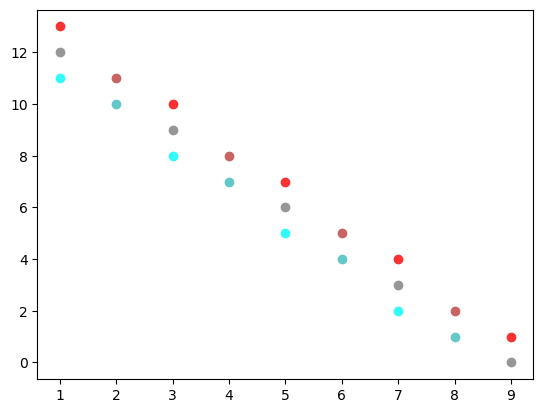

In [3]:
# the whole file uses this variable as upper bound up to which execute the classification of blowup representations
MAX_EXCESS = 4
print("MAX_EXCESS: ",MAX_EXCESS)

gn_table = [] # list of lists of tuples (g,n), indexed by excess
fig = plt.figure()
ax = fig.add_subplot()
for excess in range(0,MAX_EXCESS+1):
    ax.name = 'Excess '+str(excess)
    gn_table.append([])
    for g in range(1,floor((excess+22)/3+1)+1):
        if (excess+22-3*g+3)%2 == 0:
            n = (excess+22-3*g+3)/2
            gn_table[excess].append((g,n))
    ax.scatter(*zip(*gn_table[excess]),c='#'+str(hex(int(50+excess*200/MAX_EXCESS))[2:])+str(hex(int(50+(MAX_EXCESS-excess)*200/MAX_EXCESS))[2:])+str(hex(int(50+(MAX_EXCESS-excess)*200/MAX_EXCESS))[2:]))
plt.show()

# given a sequence of simple specht contributions (either Vn or V1^n), generate the string of their box product
def specht_sequence_to_string(seq):
    if len(seq)>0:
        specht_string = r"$"
        first=True
        for specht in seq:
            if not first: specht_string+=r"\boxtimes "
            first = False
            specht_string+=r"V_{"+ (str(specht[0]) if specht[1]==1 else (r"1^{"+str(specht[0])+r"}"))+r"}"
        specht_string+=r"$"
        return specht_string
    else: return ""

GRAPHVISUALS = True # controls wether to build graphics for the blowup objects

In [4]:
class BlowUpComponent:
    def __init__(self):
        self.nameID='-1'
        self.ID='-1'
        self.crossed=False
        self.crossType='0'
        self.stability = 0
    
        self.marked=False # vars that only make sense after marking
        self.unmarkedComponent = None
        self.odd_component= None
        self.odd = None
        self.odd_symmetry = None
        self.nadd_permutation_matrix = None
        self.specht_sequence = None 
        self.specht_string = None

        self.crossContractedComponent = None # in case B, the BlowUpComponent object isomorphic to the contraction of the crossed edge in this graph
        self.crossValence = None # valence of tilde{v}, number of hairs of half-edges incodent with the crossed edge
        self.relations2_groupID = -1 # index position of its group in the sorted dataframe relations2_groups. set externally
        self.in_relation2_basis = None # wether this component is a basis element of its relation2 group

        self.crossTypeA2_blowupComponents = None # in case A2, the one or two BlowUp component objects (unmarked or marked) after blowing up the crossed edge

    def build(self,skeleton=None, unmarked_valence=[],nadd_valence=[],doubleleg=None):
        if doubleleg==None:
            self.graph = skeleton.copy(immutable=False)  # non empty graph of the internal vertices of the components
            self.vertices = skeleton.order() #internal, and counting the potential crossed edge as two !
            if self.vertices!=len(unmarked_valence) or self.vertices!=len(nadd_valence): raise ValueError('vertices!=length arrays')
            self.edges = skeleton.size() #internal, but counting the potential crossed edge !
            self.unmarked_valence = unmarked_valence # list by index of the internal vertex of how many unmarked hairs it has
            self.nadd_valence = nadd_valence # list by index of the internal vertex of how many j hairs it has
            self.unmarked = sum(unmarked_valence)
            self.nadd = sum(nadd_valence)
            self.n = self.unmarked+self.nadd # total hairs of the components
            self.v_add = self.vertices #vertex contribution when glued to the special vertex
            self.e_add = self.edges+self.unmarked #edges contribution when glued to the special vertex

            ucount=ncount=0
            for v,u in enumerate(unmarked_valence):
                for x in range(u):
                    self.graph.add_vertex('u'+str(ucount))
                    self.graph.add_edge('u'+str(ucount),v,'u')
                    ucount += 1
            for v,n in enumerate(nadd_valence):
                for x in range(n):
                    self.graph.add_vertex('n'+str(ncount))
                    self.graph.add_edge('n'+str(ncount),v,'n')
                    ncount += 1

            for v in range(self.vertices):
                if self.graph.degree(v)<3: raise ValueError('Component not stable at vertex ',v)
                self.stability += self.graph.degree(v)-2
            self.g = (self.stability-self.n+2)/2    # total genus of the hairy graph
            self.g_add = self.g+self.unmarked-1   # genus contribution when glued to the special vertex
        else:
            if doubleleg==0:
                self.graph = Graph({'u0':['u1'],'u1':[]})
                self.graph.set_edge_label('u0','u1','u')
                self.unmarked = 2
                self.nadd = 0
                self.g_add = 1
                self.e_add = 1
            else:
                self.graph = Graph({'u0':['n0'],'n0':[]})
                self.graph.set_edge_label('u0','n0','n')  # double leg edge label is the one of its second vertex
                self.unmarked = 1
                self.nadd = 1
                self.g_add = 0
                self.e_add = 0
            self.vertices = 0
            self.edges = 0
            self.n = 2
            self.g = 0
            self.v_add = 0
        self.build_visuals()
        return self

    def cross(self,crosstype,vertex,vertex2=None):
        if self.vertices==0: raise ValueError("doubleleg can't be crossed")
        self.crossed = True
        self.crossType = crosstype
        self.v_add+= -1
        self.e_add+= -1
        # throughout the program it is assumed that self.crossedEdge[0] is the internal vertex
        if crosstype=='A':
            if self.unmarked_valence[vertex]==0: raise ValueError('No unmarked at crossed vertex',vertex)
            if self.marked:
                node_index = sum(self.ome_valence[:vertex])
                self.crossedEdge = [vertex,'o'+str(node_index)]
            else:
                node_index = sum(self.unmarked_valence[:vertex])
                self.crossedEdge = [vertex,'u'+str(node_index)]
            if self.graph.degree(vertex)==3: self.crossType='A2'
        if crosstype=='B':
            self.crossedEdge = [vertex,vertex2]
        if crosstype=='Birr':
            self.crossedEdge = [vertex,vertex]
        # if it has a multiple edge, I assume that its label has already been set at construction of the graph
        if not self.graph.has_multiple_edges(): 
            self.graph.set_edge_label(*self.crossedEdge,'CROSS')

    def compute_crossContractedComponent(self):
        # compute the splitting of the A2 graph at the crossed vertex, then search in the given frame for the BlowUpComponent objects isomorphic to the one or two resulting components.
        # this graph maintains all edge and vertex labelings, it might have vertex labels which skip one integer
        if not self.crossType=='B': raise ValueError('component is not of crossType B')
        G = copy(self.graph)
        G.allow_multiple_edges(new=True)
        G.allow_loops(new=True)
        G.contract_edge(self.crossedEdge)
        v = self.crossedEdge[0] if self.crossedEdge[0]<self.crossedEdge[1] else self.crossedEdge[1]
        G.relabel({v:'CROSS'})
        self.crossContractedComponent = G
        self.crossValence, self.crossValence_nadd, self.crossValence_eps, self.crossValence_none = 0, 0, 0, 0
        for edge in G.edges(vertices='CROSS',labels=True,sort=False):
            self.crossValence+=1
            if edge[0]==edge[1]:
                self.crossValence+=1
                self.crossValence_none+=2
            elif edge[2]==None: self.crossValence_none+=1
            elif edge[2][0]=='n': self.crossValence_nadd+=1
            elif edge[2][0]=='e': self.crossValence_eps+=1

        self.in_relation2_basis = False

    def compute_A2blowup(self,frame):
        # compute the splitting of the A2 graph at the crossed vertex, then search in the given frame for the BlowUpComponent objects isomorphic to the one or two resulting components.
        if not self.crossType=='A2': raise ValueError('component is not of crossType A2')
        self.crossTypeA2_blowupComponents = []
        components = []
        if self.graph.has_loops():
            if self.marked:
                G = Graph({'o0':['o1'],'o1':[]})
                G.set_edge_label('o0','o1','o')
            else:
                G = Graph({'u0':['u1'],'u1':[]})
                G.set_edge_label('u0','u1','u')
            components = [G]
        else:
            G = copy(self.graph) 
            G.delete_vertex(self.crossedEdge[1])
            edges = []
            for edge in G.edges(vertices=self.crossedEdge[0], sort=False,labels=True):
                if edge[2]!='CROSS': edges.append((edge[0],edge[1],edge[2]) if edge[0]==self.crossedEdge[0] else (edge[1],edge[0],edge[2]))
            if len(edges)!=2: raise ValueError('blowup at A2 went wrong',self.__str__(True))
            G.delete_edge(edges[1])
            G.relabel({self.crossedEdge[0]:'w1'})
            G.add_vertex('w2')
            G.add_edge(edges[1][1],'w2',edges[1][2])
            if edges[0][2]==None: G.set_edge_label('w1',edges[0][1],'o' if self.marked else 'u')
            if edges[1][2]==None: G.set_edge_label('w2',edges[1][1],'o' if self.marked else 'u')
            if not G.is_connected(): components = G.connected_components_subgraphs()
            else: components = [G]
        if self.marked:
            for C in components:
                eps = ome = nadd = vertices = 0
                for v in C.get_vertices():
                    if isinstance(v,str):
                        if v[0]=='o' or v[0]=='w': ome+=1
                        elif v[0]=='e': eps+=1
                        else: nadd+=1
                    else: vertices+=1
                for row in frame[(frame['ome']==ome) & (frame['eps']==eps) & (frame['nadd']==nadd) & (frame['vertices']==vertices)].itertuples():
                    if row.graph.graph.is_isomorphic(C,edge_labels=True):
                        self.crossTypeA2_blowupComponents.append(row.graph)
                        break
        else:
            for C in components:
                unmarked = nadd = vertices = 0
                for v in C.get_vertices():
                    if isinstance(v,str):
                        if v[0]=='u' or v[0]=='w': unmarked+=1
                        else: nadd+=1
                    else: vertices+=1
                for row in frame[(frame['unmarked']==unmarked) & (frame['nadd']==nadd) & (frame['vertices']==vertices)].itertuples():
                    if row.graph.graph.is_isomorphic(C,edge_labels=True):
                        self.crossTypeA2_blowupComponents.append(row.graph)
                        break

        if len(components) != len(self.crossTypeA2_blowupComponents):
            print("comps")
            for C in components: C.graphplot(edge_labels=True).show()
            print("found")
            for C in self.crossTypeA2_blowupComponents: C.show()
            raise ValueError("didn't find the isomorphic A2 blow ups in the frame")

    def label_hairs_uniquely(self):
        for x in range(self.nadd):
            for edge in self.graph.edges(vertices=['n'+str(x)],sort=False):
                self.graph.set_edge_label(edge[0],edge[1],'n'+str(x))
    def unlabel_hairs(self):
        for x in range(self.nadd):
            for edge in self.graph.edges(vertices=['n'+str(x)],sort=False):
                self.graph.set_edge_label(edge[0],edge[1],'n')

    def mark(self,ome_valence,unmarkedComponent=None,doubleleg_ome=None):
        if self.marked: raise ValueError('component has already been marked')
        self.marked = True
        self.unmarkedComponent = unmarkedComponent # reference to a not marked BlowUpComponent object
        self.ome_valence = ome_valence # number of omega hairs indexed by vertex
        self.ome = sum(ome_valence) if self.vertices!=0 else doubleleg_ome    #  number of omega hairs
        if any(self.unmarked_valence[v]<ome_valence[v] for v in range(self.vertices)): raise ValueError('ome_valence too high',self.unmarked_valence, ome_valence)
        self.eps_valence = [self.unmarked_valence[v]-ome_valence[v] for v in range(self.vertices)]
        self.eps = sum(self.eps_valence) if self.vertices!=0 else self.unmarked-doubleleg_ome   #  number of epsilon hairs
        self.excess = 3*self.g-3+3*self.eps+self.ome+2*self.nadd   # excess of blown up components

        if self.vertices==0:
            if self.unmarked==1: self.graph.relabel({'u0':'o0' if doubleleg_ome==1 else 'e0'})
            elif doubleleg_ome==0: self.graph.relabel({'u0':'e0', 'u1':'e1'})
            else: self.graph.relabel({'u0':'o0' if doubleleg_ome==2 else 'e0' , 'u1':'o0' if doubleleg_ome==1 else 'o1'})
            edge = self.graph.edges(sort=False)[0]
            if self.unmarked==1: self.graph.set_edge_label(edge[0],edge[1],'n')  # nadd has priority over omega and epsilon for labeling the edge
            else: self.graph.set_edge_label(edge[0],edge[1],'o' if doubleleg_ome==2 else 'e') # epsilon has priority over omega for labeling the edge
            self.odd_component = (doubleleg_ome%2==0 and self.nadd==0)
            if doubleleg_ome==2:
                self.odd =True
                self.odd_symmetry = 'u see it'
            else: self.odd=False
        else:
            count = ecount = ocount = 0
            for v in range(self.vertices):
                for x in range(self.eps_valence[v]):
                    self.graph.relabel({'u'+str(count):'e'+str(ecount)},inplace=True)
                    self.graph.set_edge_label('e'+str(ecount),v,'e')
                    count+=1
                    ecount+=1
                for o in range(self.ome_valence[v]):
                    self.graph.relabel({'u'+str(count):'o'+str(ocount)},inplace=True)
                    self.graph.set_edge_label('o'+str(ocount),v,'o')
                    count+=1
                    ocount+=1
            if self.crossType=='A' or self.crossType=='A2':
                o = sum(ome_valence[:self.crossedEdge[0]])
                self.crossedEdge[1] = 'o'+str(o)
                self.graph.set_edge_label(*self.crossedEdge,'CROSS')

            self.odd_component = ((self.edges + self.eps)%2!=0 and self.nadd==0 and not self.crossed)
            # a (non empty) blow up component has an odd symmetry if and only if there is a generator of the automorphism group with odd sign of permutation on the internal edges + epsilon hairs
            #the symmetry automorphisms must fix the n_add hairs, so relabel their edges from the anonymous 'n' to 'nx', where 1≤x≤n_add is the index of the hair
            self.label_hairs_uniquely()
            autom = self.graph.automorphism_group(edge_labels=True)
            self.odd = False
            self.odd_symmetry = None
            for f in autom.gens():
                sign_count = 0
                orbits = []
                for edge in self.graph.edges(sort=False,labels=True):
                    if (edge[2]==None or edge[2]=='e') and not any(({edge[0],edge[1]} in orbit) for orbit in orbits):
                        orbits.append([{edge[0],edge[1]}])
                        edge2 = (edge[0],edge[1])
                        while {f(edge2[0]),f(edge2[1])}!={edge[0],edge[1]}:
                            edge2 = (f(edge2[0]),f(edge2[1]))
                            sign_count+=1
                            orbits[len(orbits)-1].append({edge2[0],edge2[1]})                    
                if sign_count%2!=0:
                    self.odd = True
                    self.odd_symmetry = f
                    break
            #relabel to original state the n_add hairs
            self.unlabel_hairs()
            
        self.build_visuals()

    def compute_specht(self):
        # if has odd symmetry, then the sign of an action on the nadd hairs is not well defined
        if self.odd: return

        # sequence of tuples (k,o) where k is the size of a group which can be freely permuted by o-signed automorphisms
        self.specht_sequence = []
        if self.nadd==0: pass
        elif self.nadd==1:
            self.specht_sequence.append((1,1))  # this case covers also the two double legs with a nadd hair
        else:
            # indexed by pairs of hairs, 0 if there's no transposition, +-1 if there's a +-1 signed permutation
            self.nadd_transpositions_matrix = [([0]*self.nadd) for n in range(self.nadd)]
            for i in range(self.nadd): self.nadd_transpositions_matrix[i][i]=1
            autom = self.graph.automorphism_group(edge_labels=True)
            for f in autom:
                transp = [(f('n'+str(i))!='n'+str(i)) for i in range(self.nadd)]
                if transp.count(True)!=2: continue # if f is not a pure transposition on the hairs
                # find indices of potential transposition
                i1 = 0
                while not transp[i1]: i1+=1
                i2 = i1+1
                while not transp[i2]: i2+=1
                if self.nadd_transpositions_matrix[i1][i2]!=0: continue  # if this transposition has already been reviews
                sign_count = 0
                orbits = []
                for edge in self.graph.edges(sort=False,labels=True):
                    if (edge[2]==None or edge[2]=='e') and not any(({edge[0],edge[1]} in orbit) for orbit in orbits):
                        orbits.append([{edge[0],edge[1]}])
                        edge2 = (edge[0],edge[1])
                        while {f(edge2[0]),f(edge2[1])}!={edge[0],edge[1]}:
                            edge2 = (f(edge2[0]),f(edge2[1]))
                            sign_count+=1
                            orbits[len(orbits)-1].append({edge2[0],edge2[1]})    
                sign = 1 if sign_count%2==0 else -1    
                self.nadd_transpositions_matrix[i1][i2] = sign
                self.nadd_transpositions_matrix[i2][i1] = sign
            # group nadd hairs by existence of a pure transposition between any two (a transitive relation)
            symmetric_subsets = []
            for x in range(self.nadd):
                found = False
                for y in range(x):
                    if self.nadd_transpositions_matrix[x][y]!=0:
                        for subset in symmetric_subsets:
                            if y in subset:
                                subset.append(x)
                                found = True
                                break
                        if found: break
                if not found: symmetric_subsets.append([x])
            if sum([len(subset) for subset in symmetric_subsets])!=self.nadd:
                print(self.nadd_transpositions_matrix)
                print(symmetric_subsets)
                self.show(name=True)
                raise ValueError("partition of nadd hairs is wrong")
            for subset in symmetric_subsets:
                if not all((x==y) or (self.nadd_transpositions_matrix[x][y]==self.nadd_transpositions_matrix[subset[0]][subset[1]]) for x in subset for y in subset):
                    print(self.nadd_transpositions_matrix)
                    print(symmetric_subsets)
                    self.show(name=True)
                    raise ValueError("not all transpositions in partition of nadd hairs have the same sign")
                if len(subset)==1: self.specht_sequence.append((1,1))
                else: self.specht_sequence.append((len(subset),self.nadd_transpositions_matrix[subset[0]][subset[1]]))

        self.specht_string = specht_sequence_to_string(self.specht_sequence)
        


    def build_visuals(self):
        if not GRAPHVISUALS: return
        self.vertex_position = {}
        if self.marked:
            self.partition = {'vertices': [x for x in range(self.vertices)], 'eps':['e'+str(x) for x in range(self.eps)],'ome':['o'+str(x) for x in range(self.ome)], 'nadd':['n'+str(x) for x in range(self.nadd)]}
            DX = 1/(self.eps+self.ome)
            X = DX/2
            Y = 0
            for i in range(self.ome):
                self.vertex_position['o'+str(i)] = [X,Y]
                X+=DX
            for i in range(self.eps):
                self.vertex_position['e'+str(i)] = [X,Y]
                X+=DX
        else:
            self.partition = {'vertices': [x for x in range(self.vertices)], 'unmarked':['u'+str(x) for x in range(self.unmarked)], 'nadd':['n'+str(x) for x in range(self.nadd)]}
            DX = 1/(self.unmarked)
            X = DX/2
            Y = 0
            for i in range(self.unmarked):
                self.vertex_position['u'+str(i)] = [X,Y]
                X+=DX
        if self.nadd!=0:
            DX = 1/self.nadd
            X=DX/2
            Y=1
            for i in range(self.nadd):
                self.vertex_position['n'+str(i)] = [X,Y]
                X+=DX
        if self.vertices == 1 or self.vertices==2:
            DX = 1/self.vertices
            X=DX/2
            Y=0.5
            for i in range(self.vertices):
                self.vertex_position[i] = [X,Y]
                X+=DX
        elif self.vertices>=3:
            DT = 2*math.pi/self.vertices
            T = -math.pi/2-DT/2
            for i in range(self.vertices):
                self.vertex_position[i] = [0.5+cos(T)*0.45,0.5+sin(T)*0.3]
                T-=DT

    def __str__(self, long=False):
        if self.marked:
            if not long:
                name = ""
                if self.vertices==0:
                    if self.ome==1 and self.nadd==1: name="|"
                    elif self.ome==1 and self.eps==1: name=",_"
                    elif self.eps==1 and self.nadd==1: name="!"
                    elif self.eps==2: name="._"            
                elif self.crossType=='Birr':
                    if self.ome==1: name = 'oIrr'
                    elif self.eps==1: name = 'eIrr'
                else:
                    for x in range(self.ome): name+='o'
                    if self.crossType=='A' or self.crossType=='A2': name+='CR'
                    for x in range(self.eps): name+='e'
                    for x in range(self.vertices): name+='v'
                    if self.crossType=='B': name+='CR'
                    for x in range(self.nadd): name+='j'
                    if self.vertices!=1: name += str(self.nameID)
                return name
            else:
                string = f"BlowUpComponent ID {self.ID}  name: {self.__str__()}  excess: {str(self.excess)}  eps,ome,nadd: {str(self.eps)}, {str(self.ome)}, {str(self.nadd)}   vertices: {str(self.vertices)}   edges: {str(self.edges)}  g: {str(self.g)}"
                if self.crossed: string+="  crossType: "+str(self.crossType)
                if self.crossType=='B': string+=" rel2basis: "+str(self.in_relation2_basis)
                if self.odd_component: string+="  , odd edges"
                if self.odd: string+="  odd symmetry: "+str(self.odd_symmetry)
                return string
        else:
            if not long:
                name = ""
                if self.vertices==0:
                    if self.unmarked==1 and self.nadd==1: name="|"
                    elif self.unmarked==2: name="_"
                elif self.crossed and self.crossType=='Birr':
                    name = 'uIrr'
                else:
                    for x in range(self.unmarked): name+='u'
                    if self.crossType=='A' or self.crossType=='A2': name+='CR'
                    for x in range(self.vertices): name+='v'
                    if self.crossType=='B': name+='CR'
                    for x in range(self.nadd): name+='j'
                    if self.vertices!=1: name += str(self.nameID)
                return name
            else:
                string = f"UnmarkedBlowUpComponent ID: {self.ID}  name: {self.__str__()}  unmarked,nadd: {str(self.unmarked)}, {str(self.nadd)}   vertices: {str(self.vertices)}   edges: {str(self.edges)}  g: {str(self.g)}  stability: {self.stability}"
                if self.crossed: string+="  crossType: "+str(self.crossType)
                if self.crossType=='B': string+=" rel2basis: "+str(self.in_relation2_basis)
                return string
    
    def show(self,name=False,title=False, specht=False,graphics=False):
        if name: print(self.__str__(True))
        graphplot_object = {}
        if self.marked:
            if not self.crossed:
                graphplot_object = self.graph.graphplot(edge_labels=True, edge_labels_background='#FFFFFF90', pos=self.vertex_position,vertex_colors={'darkgrey':self.partition['vertices'], 'gold':self.partition['eps'],'dodgerblue':self.partition['ome'], 'lime':self.partition['nadd']})
            else:
                graphplot_object = self.graph.graphplot(edge_labels=True, edge_labels_background='#FFFFFF90', pos=self.vertex_position, edge_colors={'red':[self.crossedEdge]},vertex_colors={'darkgrey':self.partition['vertices'], 'gold':self.partition['eps'],'dodgerblue':self.partition['ome'], 'lime':self.partition['nadd']})
        else:
            if not self.crossed:
                graphplot_object = self.graph.graphplot(edge_labels=True, edge_labels_background='#FFFFFF90', pos=self.vertex_position,vertex_colors={'darkgrey':self.partition['vertices'], 'sandybrown':self.partition['unmarked'], 'lime':self.partition['nadd']})
            else:
                graphplot_object = self.graph.graphplot(edge_labels=True, edge_labels_background='#FFFFFF90', pos=self.vertex_position, edge_colors={'red':[self.crossedEdge]},vertex_colors={'darkgrey':self.partition['vertices'], 'sandybrown':self.partition['unmarked'], 'lime':self.partition['nadd']})
        if title and not specht: graphplot_object = graphplot_object.plot(axes=False, title=f'ID: {self.ID}    {self.__str__()}')
        elif title and specht: graphplot_object = graphplot_object.plot(axes=False, title=f'ID: {self.ID}    {self.specht_string}')
        if not graphics: graphplot_object.show()
        else:  return graphplot_object

In [5]:
def generate_UnmarkedBlowUpComponents(unmarked,nadd,vertices,genus):
    #return a list of not marked blowup components objects which contains all graphs with the following features:
    # connected, with given number of internal vertices and of total genus
    # with unmarked+nadd hairs partitioned in the two families by labeling their edges as 'u' or 'n'
    # at least trivalent (internal) vertices (i.e. stable)
    # either:  simple 
    #    or:   simple and has a crossed unmarked hair
    #    or:   has a crossed internal edge, is simple
    #    or:   has a crossed internal edge, is simple except for having exactly one multiple edge parallel the crossed edge

    # The remaining 4 unmarked graphs of interest (2 double legs, A2 case with loop at its end and Birr case) are added manually afterwards.
    
    pool_skeletons = graphs.nauty_geng(str(vertices)+" -c") # all connected graphs with given vertices
    pool_UnmarkedComponents = []
    pool_UnmarkedCrossedInt = []
    pool_UnmarkedCrossedOme = []
    pool_UnmarkedCrossedIntMultiple = []

    n_hairs = Subsets(list(range(vertices))*nadd,nadd,submultiset=True) #all multisubsets of the vertices with size n_add
    unm_hairs = Subsets(list(range(vertices))*unmarked,unmarked,submultiset=True) #all multisubsets of the vertices with size unmarked
    for skeleton in pool_skeletons:
        #skip skeletons with wrong genus (or not of g-1), as they will be considered for another value of the excess
        g = sum([skeleton.degree(v)-2 for v in range(vertices)])/2+1
        if genus==g:
            pool_UnmarkedComponents.append([])
            pool_UnmarkedCrossedInt.append([])
            pool_UnmarkedCrossedOme.append([])
            pool_UnmarkedCrossedIntMultiple.append([])
            for f_unm in unm_hairs:
                for f_n in n_hairs:
                    unmarked_valence = [f_unm.count(v) for v in range(vertices)]
                    nadd_valence = [f_n.count(v) for v in range(vertices)]

                    # if stable at every vertex
                    if all((skeleton.degree(v)+unmarked_valence[v]+nadd_valence[v]>=3) for v in range(vertices)):    
                        GR = BlowUpComponent().build(skeleton,unmarked_valence,nadd_valence)
                        #up to isomorphism of hairy graphs with labeled hairs. It is sufficient to check isomorphism with previous graphs which have the same skeleton S
                        if not any((G.graph.is_isomorphic(GR.graph, edge_labels=True)) for G in pool_UnmarkedComponents[-1]):
                            pool_UnmarkedComponents[-1].append(GR)
                        
                            #crossed at internal edge
                            for edge in skeleton.edges(sort=False):
                                GRcrossedB =  BlowUpComponent().build(skeleton,unmarked_valence,nadd_valence)
                                GRcrossedB.cross('B',edge[0],edge[1])
                                #up to isomorphism of hairy graphs with labeled hairs and crossed edge
                                if not any((G.graph.is_isomorphic(GRcrossedB.graph, edge_labels=True)) for G in pool_UnmarkedCrossedInt[-1]):
                                    pool_UnmarkedCrossedInt[-1].append(GRcrossedB)

                            #crossed at omega hair. Up to isomorphism, there is only one way of crossing for every internal vertex with an omega hair
                            for v in range(vertices):
                                if unmarked_valence[v]!=0:
                                    GRcrossedA = BlowUpComponent().build(skeleton,unmarked_valence,nadd_valence)
                                    GRcrossedA.cross('A',v)
                                    #up to isomorphism of hairy graphs with labeled hairs and crossed edge
                                    if not any((G.graph.is_isomorphic(GRcrossedA.graph, edge_labels=True)) for G in pool_UnmarkedCrossedOme[-1]):
                                        pool_UnmarkedCrossedOme[-1].append(GRcrossedA)
        elif genus-1==g: 
            pool_UnmarkedComponents.append([])
            pool_UnmarkedCrossedInt.append([])
            pool_UnmarkedCrossedOme.append([])
            pool_UnmarkedCrossedIntMultiple.append([])
            for f_unm in unm_hairs:
                for f_n in n_hairs:
                    unmarked_valence = [f_unm.count(v) for v in range(vertices)]
                    nadd_valence = [f_n.count(v) for v in range(vertices)]
                    # try also adding a parallel edge in every possible way and crossing the component
                    multiedged = {}
                    for edge in skeleton.edges(sort=False):
                        multiedged = skeleton.copy(immutable=False)
                        multiedged.allow_multiple_edges(new=True)
                        multiedged.add_edge(edge[0],edge[1],'CROSS') # have to label as crossed already
                        # if it has become stable
                        if all((multiedged.degree(v)+unmarked_valence[v]+nadd_valence[v]>=3) for v in range(vertices)):
                            GR = BlowUpComponent().build(multiedged,unmarked_valence,nadd_valence)
                            GR.cross('B',edge[0],edge[1])
                            if not any((G.graph.is_isomorphic(GR.graph, edge_labels=True)) for G in pool_UnmarkedCrossedIntMultiple[-1]):
                                    pool_UnmarkedCrossedIntMultiple[-1].append(GR)

    #unwrap list of lists
    return [G for pool in pool_UnmarkedComponents for G in pool]+[G for pool in pool_UnmarkedCrossedInt for G in pool]+[G for pool in pool_UnmarkedCrossedOme for G in pool]+[G for pool in pool_UnmarkedCrossedIntMultiple for G in pool]

In [6]:
unmarked_components = pd.DataFrame(columns=['ID','name','unmarked','nadd','vertices','stability','g','crossed','crossType','graph'])
def add_UnmarkedBlownUpComponent(G):
    unmarked_components.loc[len(unmarked_components)] = {'name':G.__str__(),'graph':G,'unmarked':G.unmarked,'nadd':G.nadd,'vertices':G.vertices,'stability':G.stability,'g':G.g, 'crossed':G.crossed,'crossType':G.crossType}

visited = []
for excess in range(0,MAX_EXCESS+1):
    for unmarked in range(1,excess+4):
        for n_add in range(floor((excess+3-unmarked)/2)+1):
            for genus in range(floor((excess+3-unmarked-2*n_add)/3)+1):
                n = unmarked+n_add
                stability = 2*genus-2+unmarked+n_add #the stability parameter gives an upper bound for the number of vertices of stable graphs
                for vertices in range(1,stability+1):
                    if (unmarked,n_add,vertices,genus) in visited: continue
                    visited.append((unmarked,n_add,vertices,genus))

                    components = generate_UnmarkedBlowUpComponents(unmarked,n_add,vertices,genus)
                    for G in components:
                        add_UnmarkedBlownUpComponent(G)
UTRIPOD = unmarked_components[(unmarked_components['vertices']==1)&(unmarked_components['unmarked']==3)&(unmarked_components['nadd']==0)].iloc[int(0)].graph

UU_HAIR = BlowUpComponent().build(doubleleg=0)
add_UnmarkedBlownUpComponent(UU_HAIR)
UJ_HAIR = BlowUpComponent().build(doubleleg=1)
add_UnmarkedBlownUpComponent(UJ_HAIR)
UA2IRR = BlowUpComponent().build(Graph({0:[0]}),[1],[0])
UA2IRR.cross('A',0)
add_UnmarkedBlownUpComponent(UA2IRR)
UBIRR = BlowUpComponent().build(Graph({0:[0]}),[1],[0])
UBIRR.cross('Birr',0)
add_UnmarkedBlownUpComponent(UBIRR)

#set short name id of the components
namegrouped = unmarked_components.groupby('name')
for namegroup in namegrouped.groups.keys():
    sorted = namegrouped.get_group(namegroup).sort_values(by=['crossType','vertices','nadd']).reset_index(drop=True)
    for row in sorted.itertuples():
        row.graph.nameID=str(row.Index)
        row.graph.graph.name(new=row.graph.__str__())
unmarked_components['name'] = unmarked_components['graph'].apply(lambda G: G.__str__())
#verify that every nameID is unique
namegrouped = unmarked_components.groupby('name')
for namegroup in namegrouped.groups.keys():
    if len(namegrouped.get_group(namegroup))>int(1):
        for G in namegrouped.get_group(namegroup).itertuples(): G.graph.show()
        raise ValueError('nameID not unique',namegrouped.get_group(namegroup))
    
unmarked_components.sort_values(by=['crossType','nadd','unmarked','vertices','stability'],inplace=True)
unmarked_components.reset_index(drop=True,inplace=True)
unmarked_components['ID'] = unmarked_components.index  # copying the index in an extra column helps for bookkeeping when the k-fold cartesian product of the dataframe is taken later
for row in unmarked_components.itertuples():
        row.graph.ID=int(row.ID)

print("unmarked_components shape:")
print(unmarked_components.groupby(['vertices']).size())

unmarked_components shape:
vertices
0      2
1     28
2     73
3    103
4     64
5     13
dtype: int64


In [7]:
for G in unmarked_components[(unmarked_components['crossType']=='A2') & (unmarked_components['vertices']<=2)].itertuples():
    break
    G.graph.show(True)

for row in unmarked_components[unmarked_components['crossType']=='A'].itertuples():
    break
    if row.graph.graph.has_multiple_edges(): row.graph.show(True)

In [8]:
def generate_blowup_components(eps,ome,nadd,g):
    #return a list of marked blowup components objects which is obtained from the list unmarked_components by dividing in every possible way the unmarked hairs in two families eps and ome, such that:
    # the unmarked component has an internal vertex, genus g, eps+ome unmarked hairs and nadd nadd hairs

    # the case A2 with a loop at its end and the case Birr with eps/ome hairs are added by this function
    # The remaining graphs of interest (5 double legs) are added manually afterwards.

    # In excess ≤3, every case B graph with a multiple edge parallel to the crossed edge vanishes bc of odd symmetry, so we need not consider it.

    # At this level, the nadd hairs are not uniquely labeled because we care about blow up components up to isomorphisms that are allowed to permute them,
    #   afterwards, we will relabel them uniquely in all possible ways that create non isomorphic blow up representations
    
    pool_components = [] # list of lists of blow up components, for every unmarked_component

    for unmarked_component in unmarked_components[(unmarked_components['vertices']!=0) & (unmarked_components['g']==g) & (unmarked_components['unmarked']==eps+ome) & (unmarked_components['nadd']==nadd)].itertuples():
        unmarked_graph = unmarked_component.graph
        
        unmarked_valence_multiset = []
        for v,u in enumerate(unmarked_graph.unmarked_valence):
            for x in range(u): unmarked_valence_multiset.append(v)
        
        ome_multisets = Subsets(unmarked_valence_multiset,ome,submultiset=True) # all multisubsets of the vertices with size ome

        pool_components.append([])
        for f_ome in ome_multisets:
            # case A requires at least one omega hair at the crossed edge
            if (unmarked_graph.crossType=='A' or unmarked_graph.crossType=='A2') and not unmarked_graph.crossedEdge[0] in f_ome: continue
            
            ome_valence = [f_ome.count(v) for v in range(unmarked_graph.vertices)]
            marked_graph = deepcopy(unmarked_graph)
            marked_graph.mark(ome_valence,unmarkedComponent=unmarked_graph)
            #up to isomorphism of hairy graphs with labeled hairs. It is sufficient to check isomorphism with previous graphs which have the same unmarked component
            if not any((G.graph.is_isomorphic(marked_graph.graph, edge_labels=True)) for G in pool_components[-1]):
                pool_components[-1].append(marked_graph)
    #unwrap list of lists
    return [G for pool in pool_components for G in pool]

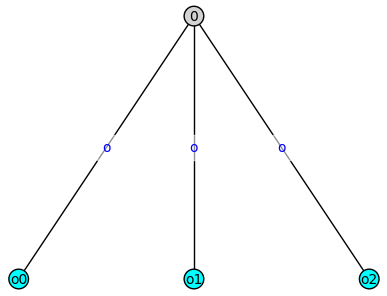

blowup_components shape:
excess  g  odd  
-1      0  True       1
0       0  False      3
1       0  False      8
        1  False      2
2       0  False     19
           True       2
        1  False      1
3       0  False     55
           True       8
        1  False      4
           True       3
4       0  False    168
           True      24
        1  False     18
           True      12
        2  True       1
dtype: int64


In [9]:
blowup_components = pd.DataFrame(columns=['ID','unmarkedID','name','excess','eps','ome','nadd','vertices','stability','g','n','crossed','crossType','odd','odd_component','graph'])
def add_BlownUpComponent(G):
    blowup_components.loc[len(blowup_components)] = {'graph':G,'excess':G.excess,'eps':G.eps,'ome':G.ome,'nadd':G.nadd,'n':G.n,'vertices':G.vertices,'stability':G.stability,'g':G.g,'crossed':G.crossed, 'crossType':G.crossType,'odd':G.odd,'odd_component':G.odd_component,'name':G.__str__(),'unmarkedID':G.unmarkedComponent.ID}

def unmarkedCompID_fromCompID(i): return blowup_components.iloc[i].graph.unmarkedComponent.ID

for excess in range(0,MAX_EXCESS+1):
    for ome in range(excess+4):
        for eps in range(floor((excess+3-ome)/3)+1):
            if eps+ome>=1:
                for n_add in range(floor((excess+3-3*eps-ome)/2)+1):
                    n = eps+ome+n_add
                    if (excess+3-3*eps-ome-2*n_add)%3!=0: continue
                    genus = (excess+3-3*eps-ome-2*n_add)/3
                    components = generate_blowup_components(eps,ome,n_add,genus)
                    for G in components:
                        add_BlownUpComponent(G)

TRIPOD = blowup_components.loc[(blowup_components['vertices']==1) & (blowup_components['eps']==0) & (blowup_components['ome']==3) & (blowup_components['nadd']==0)& (blowup_components['crossed']==False)].iloc[int(0)].graph
# TRIPOD.show()

#BONUS GRAPHS: the double legs o-j  e-j  o-e  e-e,  o--crossed--v--loop,  irreducible e--v--crossedloop
OJ_HAIR= deepcopy(UJ_HAIR)
OJ_HAIR.mark([],unmarkedComponent=UJ_HAIR,doubleleg_ome=1)
add_BlownUpComponent(OJ_HAIR)
EJ_HAIR = deepcopy(UJ_HAIR)
EJ_HAIR.mark([],unmarkedComponent=UJ_HAIR,doubleleg_ome=0)
add_BlownUpComponent(EJ_HAIR)
OO_HAIR= deepcopy(UU_HAIR)
OO_HAIR.mark([],unmarkedComponent=UU_HAIR,doubleleg_ome=2)
add_BlownUpComponent(OO_HAIR)
EO_HAIR = deepcopy(UU_HAIR)
EO_HAIR.mark([],unmarkedComponent=UU_HAIR,doubleleg_ome=1)
add_BlownUpComponent(EO_HAIR)
EE_HAIR = deepcopy(UU_HAIR)
EE_HAIR.mark([],unmarkedComponent=UU_HAIR,doubleleg_ome=0)
add_BlownUpComponent(EE_HAIR)
# OA2IRR = deepcopy(UA2IRR) # these two are already added by the generating function above
# OA2IRR.mark([1])
# add_BlownUpComponent(OA2IRR)
# EBIRR = deepcopy(UBIRR)
# EBIRR.mark([0])
# add_BlownUpComponent(EBIRR)

blowup_components.sort_values(by=['crossType','excess','vertices','nadd','eps','odd'],inplace=True)
blowup_components.reset_index(drop=True,inplace=True)
blowup_components['ID'] = blowup_components.index  # copying the index in an extra column helps for bookkeeping when the k-fold cartesian product of the dataframe is taken later
for row in blowup_components.itertuples(): row.graph.ID=int(row.ID)

for row in blowup_components[blowup_components['crossType']=='A2'].itertuples(): row.graph.compute_A2blowup(blowup_components)

print("blowup_components shape:")
print(blowup_components.groupby(['excess','g','odd']).size())

In [10]:
for row in blowup_components.itertuples():
    row.graph.compute_specht()

In [11]:
for row in blowup_components[blowup_components['graph'].apply(lambda G: G.excess==4 and G.crossType=='BB')].itertuples():
    break
    row.graph.show(True,title=True,specht=True)


In [12]:
relations2_groups = pd.DataFrame(columns=['graphs_ID_set','excess','ome','eps','nadd','g','vertices','crossContractedComponent','valence','valence_none','valence_eps','valence_nadd','graphs','basis','basis_ID_set'])
# graphs (and graphs_ID_set) is a list of BlowUpComponent objects in case B whose contraction results in the same graph
# valence is the amount of hairs of halfedges incident with the crossed edge, the 'valence' of tilde{v} in the paper
# basis (and basis_ID_set) is a sublist of graphs which spans a basis through the weight 2 relations and 3b relation
# the other columns are invariants of each relation 2 group

for row in blowup_components[blowup_components['crossType']=='B'].itertuples():
    # don't consider odd components right away because it makes the job of determining the weight 2 relation group basis easier -- actually I do
    
    row.graph.compute_crossContractedComponent()
    for row2 in relations2_groups[(relations2_groups['g']==row.g) & (relations2_groups['ome']==row.ome) & (relations2_groups['eps']==row.eps) & (relations2_groups['nadd']==row.nadd) & (relations2_groups['vertices']==row.vertices-1) & (relations2_groups['valence']==row.graph.crossContractedComponent.degree('CROSS'))].itertuples():
        if row2.crossContractedComponent.is_isomorphic(row.graph.crossContractedComponent, edge_labels=True):
            row2.graphs.append(row.graph)
            break
    else:
        relations2_groups.loc[len(relations2_groups)] = {'excess': row.excess,'eps': row.eps,'ome': row.ome,'nadd': row.nadd, 'g': row.g, 'vertices': row.vertices-1, 'crossContractedComponent': row.graph.crossContractedComponent, 'valence':row.graph.crossValence, 'valence_none':row.graph.crossValence_none, 'valence_nadd':row.graph.crossValence_nadd, 'valence_eps':row.graph.crossValence_eps,'graphs': [row.graph], 'basis':[]}
relations2_groups.sort_values(['excess','nadd','eps','vertices'],inplace=True)
relations2_groups.reset_index(drop=True,inplace=True)
relations2_groups['graphs_ID_set'] = relations2_groups['graphs'].apply(lambda row: tuple([G.ID for G in row]))
for row in relations2_groups.itertuples():
    for G in row.graphs: G.relations2_groupID=int(row.Index)


# compute basis after applying weight 2 relations and 3b relation
# DONE MANUALLY
def weight2basis_raise(e,v,graph=None):
    if graph: graph.show(True)
    raise ValueError(f"weight 2 basis computation: unhandled case   excess: {e}, valence: {v}")
for row in relations2_groups.itertuples():
    if row.valence==4:
        if not row.crossContractedComponent.has_loops(): row.basis.append(row.graphs[0])
        else: pass # valence 4 with multiple edges are killed
    elif row.excess==1: weight2basis_raise(row.excess,row.valence)
    elif row.excess==2:
        if not row.crossContractedComponent.has_loops(): row.basis.extend(row.graphs)
        else: weight2basis_raise(row.excess,row.valence, row.graphs[0])
    elif row.excess==3:
        if row.crossContractedComponent.has_loops(): pass  # In excess 3, the unique valence 5 graph with multiple edge is killed
        else: row.basis.extend(row.graphs) # there's 3 groups of valence 5,5,6 of basis length 2
    elif row.excess==4:
        if row.valence==5:
            if row.crossContractedComponent.has_loops(): pass # there are two groups, each with two graphs with loops and two indipendent equations
            elif row.crossContractedComponent.has_multiple_edges(): pass # there is one group with one graph, which is killed by an equation
            elif row.valence_none==2: pass # there is one group with one graph, which is killed by odd symmetry and weight 2 relations
            elif row.valence_none==1 and row.valence_nadd==1: row.basis.extend(row.graphs[:3]) # there is one group with four graphs and one equation
            elif row.valence_nadd==2: # there is one group with three graphs with two nadd hairs and one equation between V2 specht contributions
                first=True
                for G in row.graphs:
                    if len(G.specht_sequence)==1 and first: # specht contribution V2
                        row.basis.append(G)
                        first=False
                    elif len(G.specht_sequence)==2: row.basis.append(G) # specht contribution V1^2 + V2
            else: row.basis.extend(row.graphs)
            # relation 3b imposes one equation with non zero coefficients on the weight 2 relation group, so a basis is given by excluding any element
        elif row.valence==6:
            if not row.crossContractedComponent.has_loops(): row.basis.extend(row.graphs)
            else: row.basis.append(row.graphs[0]) # there's 1 group with two graphs with a loop, and one equation
        elif row.valence==7:
            row.basis.extend(row.graphs)
        else: weight2basis_raise(row.excess,row.valence)
    else: weight2basis_raise(row.excess,row.valence)

relations2_groups['basis_ID_set'] =  relations2_groups['basis'].apply(lambda row: tuple([G.ID for G in row]))
for row in relations2_groups.itertuples():
    for G in row.graphs: G.in_relation2_basis = G in row.basis
    
print("relations2_groups size: ")
print(relations2_groups.groupby(['excess','g']).size())

for row in relations2_groups[relations2_groups['graphs'].apply(lambda graphs: len(graphs)>0 and graphs[0].excess==4 and graphs[0].crossValence==7)].itertuples():
    break
    print(f'excess: {row.excess}, g: {row.g}, valence,none,nadd,eps: {row.valence},{row.valence_none},{row.valence_nadd},{row.valence_eps}, graphs ID: {row.graphs_ID_set}, basis ID: {row.basis_ID_set}')
    row.crossContractedComponent.graphplot(edge_labels=True).show()
    for G in row.graphs: G.show(title=True,specht=True)

relations2_groups size: 
excess  g
1       0     1
2       0     3
        1     1
3       0    10
        1     4
4       0    30
        1    16
        2     1
dtype: int64


In [13]:
# Build collection of all components, up to isomorphism, up to odd symmetry, and up to relations (at least the ones that can be checked on the individual connected components).
# When a list of these components is glued to the special vertex, they may still have odd symmetry (by permuting isomorphic components with odd edges) or relations due to the special vertex decoration in weight 13.

# The dataframe of blowup_components that will be used later to construct all different blowup representations of graphs
blowup_components_basis = blowup_components

# relations 2 and 3b:  keep only blowup components which are contained in the basis of their respective relation2_group determined above
blowup_components_basis = blowup_components_basis[blowup_components_basis['graph'].apply(lambda G: G.crossType!='B' or G.in_relation2_basis)]

# A2 case with OO_HAIR: removed through weight 13 relations and 4ab relation
blowup_components_basis = blowup_components_basis[blowup_components_basis['graph'].apply(lambda G: G.crossType!='A2' or OO_HAIR not in G.crossTypeA2_blowupComponents)]

# odd symmetries are part of the relations created by coinvariants
blowup_components_basis = blowup_components_basis[(blowup_components_basis['odd']==False)]

print('blowup_components_basis size: ')
print(blowup_components_basis.groupby(['excess','g']).size())

for G in blowup_components_basis[(blowup_components_basis['excess']<=2) & (blowup_components_basis['odd']==True)].itertuples():
    break
    G.graph.show(True)


blowup_components_basis size: 
excess  g
0       0      2
1       0      6
        1      1
2       0     15
3       0     44
        1      1
4       0    128
        1      7
dtype: int64


In [14]:
class BlowUpGraph:
    # wrapper object for lists of blown up components, i.e. what uniquely determines the blown up representation of a graph
    def __init__(self,components):
        self.ID = -1
        if len(components)==0: raise ValueError("No components fed")
        self.components = components
        self.components.sort(key=lambda C: C.ID)  # list of marked BlowUpComponent objects
        self.unmarked_components = [C.unmarkedComponent for C in components] # list of unmarked BlowUpComponent objects
        self.crossedComponent=None    # BlowUpComponent object in the list which is crossed
        for C in components:
            if C.crossed:
                self.crossedComponent = C
                break
        if self.crossedComponent==None: raise ValueError("no crossed components")
        self.crossType = self.crossedComponent.crossType
        self.partition = [] # excess partition
        for C in components: self.partition.append(C.excess)
        self.partition = tuple(self.partition)

        self.eps_nadd_factor = 0 # a simple measure for heavily the eps hairs are distributed on components with hairs, used in case B and Birr to sort graphs in their relation11 group
        for C in self.components: self.eps_nadd_factor += (C.eps+int(C.crossed))*C.nadd

        #parameters of blown up graph obtained through gluing the components to the special vertex of genus 1
        self.n = sum(G.nadd for G in components)   # number of hairs
        self.unmarked = sum(G.unmarked for G in components) # number of elements in the set A
        self.eps = sum(G.eps for G in components)   #number of elements in the set A\B of the decoration
        self.ome = sum(G.ome for G in components)   # number of elements in the set B of the decoration
        if self.ome>11: raise ValueError('ome value too high',self.ome)
        if self.unmarked!=self.ome+self.eps: raise ValueError('unmarked is not ome + eps',self.unmarked)
        self.excess = sum(G.excess for G in components) # excess of the glued graph
        self.g = 1+sum(G.g_add for G in components)  # total genus of the glued graph
        if self.excess!=(3*self.g-3+2*self.n - 2*self.ome): raise ValueError(f"excess formula does not match: {self.excess}!={(3*self.g-3+2*self.n - 2*self.ome)}")
        self.vertices = 1+sum(G.v_add for G in components) #internal vertices of the glued graph, identifying the crossed edge as one vertex
        self.edges = sum(G.e_add for G in components) #internal edges, not counting the crossed edge

        self.virtual_gn_range = [] # the possible (g,n) tuples to which this blowup can be completed
        for (g,n) in gn_table[self.excess]:
            if g>=self.g and n>=self.n and (g-self.g)%2==0:
                oj_hairs = n-self.n
                tripods = ((g-self.g)/2)
                if 11==3*tripods+self.ome+oj_hairs: self.virtual_gn_range.append((g,n))
                else: raise ValueError("mismatch in omega hairs of possible completion")
        self.virtual_gn_range=tuple(self.virtual_gn_range)

        self.build_visuals()

        self.specht_sequence = [] # list of tuples (k,o)
        visited_ID = []
        for C in self.components:
            if C.ID in visited_ID or C.nadd==0: continue
            visited_ID.append(C.ID)
            multiplicity = [F.ID for F in self.components].count(C.ID) # amount of components isomotphic to C in this graph
            if multiplicity==1:
                self.specht_sequence.extend(C.specht_sequence)
            elif C.nadd==1: # the only case I need to handle, fortunately
                # the resulting action on these components has sign +-1 depending upon wether C has odd internal edges + epsilon hairs  (or is the oj_hair and is not the eps_hair)
                if (C.vertices==0 and C.ome==1) or (C.vertices>0 and (C.edges+C.eps)%2!=0):
                    self.specht_sequence.append((multiplicity,-1))
                else: self.specht_sequence.append((multiplicity,1))
            else:
                print(self.__str__(True))
                self.show(title=True,specht=True)
                raise ValueError("uncovered case in computing specht sequence of BlowUpGraph object")
        self.specht_string=r""
        if len(self.specht_sequence)>0:
            self.specht_string = r"$"
            first=True
            for specht in self.specht_sequence:
                if not first: self.specht_string+=r"\boxtimes "
                first = False
                self.specht_string+=r"V_{"+ (str(specht[0]) if specht[1]==1 else (r"1^{"+str(specht[0])+r"}"))+r"}"
            self.specht_string+=r"$"

    def build_visuals(self):
        if not GRAPHVISUALS: return
        self.vertex_partition = {'vertices':[],'eps':[],'ome':[],'nadd':[]}
        for c,C in enumerate(self.components):
            self.vertex_partition['vertices'] = self.vertex_partition['vertices']+[(str(c)+','+str(x)) for x in range(C.vertices)]
            self.vertex_partition['eps'] = self.vertex_partition['eps']+[(str(c)+',e'+str(x)) for x in range(C.eps)]
            self.vertex_partition['ome'] = self.vertex_partition['ome']+[(str(c)+',o'+str(x)) for x in range(C.ome)]
            self.vertex_partition['nadd'] = self.vertex_partition['nadd']+[(str(c)+',n'+str(x)) for x in range(C.nadd)]
        
        self.vertex_position = {}
        node_width = 1/6
        max_nodes_per_row=[max([C.ome+C.eps,C.vertices,C.nadd]) for C in self.components]
        width = 0.4+sum(max_nodes_per_row)*node_width
        component_widths=[width*max_nodes_per_row[c]/sum(max_nodes_per_row) for c,C in enumerate(self.components)]
        height = 0.7
        XX = 0
        for c,C in enumerate(self.components):
            DX = component_widths[c]/(C.eps+C.ome)
            X = XX+DX/2
            Y = 0
            for i in range(C.ome):
                self.vertex_position[str(c)+',o'+str(i)] = [X,Y]
                X+=DX
            for i in range(C.eps):
                self.vertex_position[str(c)+',e'+str(i)] = [X,Y]
                X+=DX
            if C.nadd!=0:
                DX = component_widths[c]/C.nadd
                X=XX+DX/2
                if C.vertices==0 and C.ome!=0: Y=height*0.5 # oj_hairs
                elif C.vertices==0: Y=height*0.75 # ej_hairs
                else: Y = height
                for i in range(C.nadd):
                    self.vertex_position[str(c)+',n'+str(i)] = [X,Y]
                    X+=DX
            Y=height/2
            if C.vertices == 1 or C.vertices==2:
                DX = component_widths[c]/C.vertices
                X=XX+DX/2
                for i in range(C.vertices):
                    self.vertex_position[str(c)+','+str(i)] = [X,Y]
                    X+=DX
            elif C.vertices>=3:
                DT = 2*math.pi/C.vertices
                T = -math.pi/2-DT/2
                for i in range(C.vertices):
                    self.vertex_position[str(c)+','+str(i)] = [XX+component_widths[c]/2+component_widths[c]*cos(T)*0.45,height/2+sin(T)*height/4]
                    T-=DT
            XX+=component_widths[c]
        
        self.UnitedGraph = Graph({},loops=True)
        self.crossedEdge = []
        self.UnitedGraph.add_vertices(self.vertex_partition['vertices']+self.vertex_partition['eps']+self.vertex_partition['ome']+self.vertex_partition['nadd'])
        for c,C in enumerate(self.components):
            for edge in C.graph.edges(sort=False,labels=True):
                self.UnitedGraph.add_edge(str(c)+','+str(edge[0]),str(c)+','+str(edge[1]),edge[2])
                if C.crossed: self.crossedEdge = (str(c)+','+str(C.crossedEdge[0]),str(c)+','+str(C.crossedEdge[1]))

    def __str__(self, long=False):
        if not long:
            name=""
            for c in self.components:
                name+=c.__str__()+' '
            return name
        return f"BlowUpGraph; Excess: {str(self.partition)}  g: {str(self.g)}  n: {str(self.n)}   vertices: {str(self.vertices)}  edges: {str(self.edges)} crossType: {str(self.crossType)}"
    
    def show(self,name=False,title=False,gn_range=False,specht=False,graphics=False):
        if name: print(self.__str__(True))
        kwds = {'fontsize':8}

        graphplot_object = self.UnitedGraph.graphplot(vertex_labels=False , vertex_size=30,vertex_colors={'darkgrey':self.vertex_partition['vertices'], 'gold':self.vertex_partition['eps'],'dodgerblue':self.vertex_partition['ome'], 'lime':self.vertex_partition['nadd']}, pos=self.vertex_position, edge_colors={'red':[self.crossedEdge]},**kwds)
        if title:
            titlestring = f'ID: {self.ID}'
            if gn_range:
                titlestring+=f'   n: '
                for (g,n) in self.virtual_gn_range:
                    titlestring+=f'{str(n)} '
            if specht and gn_range: titlestring = self.specht_string + "\n" + titlestring
            elif specht:  titlestring = titlestring+"     "+self.specht_string
            graphplot_object = graphplot_object.plot(axes=False, title=titlestring, fontsize=11)
        else: graphplot_object = graphplot_object.plot(axes=False)
        if not graphics: graphplot_object.show()
        else:  return graphplot_object


In [15]:
blowups = pd.DataFrame(columns=['excess','partition','comp_ID_set','unmarkedComp_ID_set','A2Comp_ID_set','g','n','vertices','edges','graph','crossType'])
# Generate all (unordered) collections of components in blowup_components_basis (of excess >=1) which have:
# -- exactly one crossed component
# -- excesses summing up to MAX_EXCESS
# -- at maximum one not crossed component with the odd_component attribute (to avoid odd symmetries of the glued graph)

def partitions(n, I=1):
    yield (n,)
    for i in range(I, n//2 + 1):
        for p in partitions(n-i, i):
            yield (i,) + p

grouped_components = blowup_components_basis.groupby(['excess','crossed'])
for E in range(1,MAX_EXCESS+1):
    for partition in partitions(E):
        #there has to be exactly one crossed component, which has to be chosen without repetition nor order
        crossed_visited = []
        for crossedchoice in range(len(partition)):
            if partition[crossedchoice] in crossed_visited: continue
            crossed_visited.append(partition[crossedchoice])
            
            #form the cartesian product of selected subsets of blowup_components_basis
            components_array = grouped_components.get_group((partition[0],0==crossedchoice))
            components_array = components_array[['ID','graph']].add_suffix('_0')
            id_columns = ['ID_0']
            graph_columns = ['graph_0']
            for i in range(1,len(partition)):
                components_array = components_array.merge(grouped_components.get_group((partition[i],i==crossedchoice))[['ID','graph']].add_suffix('_'+str(i)), how='cross')
                id_columns.append('ID_'+str(i))
                graph_columns.append('graph_'+str(i))
            #remove duplicates up to reordering of the components in cartesian product
            #components_array = components_array.assign(comp_ID_set=lambda row: row[id_columns].apply(lambda l: sorted(list(l)),axis=1) ) # does not work for the love of god
            def sort_inplace(row): row.sort()
            components_array = components_array.assign(comp_ID_set=lambda row: row[id_columns].values.tolist() )
            components_array['comp_ID_set'].apply(sort_inplace)
            components_array.drop_duplicates(subset=['comp_ID_set'],inplace=True)

            #if at least two elements are not crossed, remove entries with at least two components with the odd_component attribute
            if len(partition)>2:
                def double_odd_check(row):
                    odd_components=[]
                    for C in list(row):
                        if C.odd_component:
                            if any(C_ is C for C_ in odd_components): return True
                            odd_components.append(C)
                    return False
                components_array = components_array.assign(has_double_odd=lambda row: row[graph_columns].apply(double_odd_check,axis=1))
                components_array = components_array[components_array['has_double_odd']==False]
            
            # construct the BlowUpGraph objects and store them in the dataframe
            for row in components_array[graph_columns+['comp_ID_set']].itertuples():
                components = list(row[1:-1])
                if sum([C.ome for C in components])>11: continue
                G = BlowUpGraph(components)
                comp_ID_set = [C.ID for C in components]
                comp_ID_set.sort()
                comp_ID_set = tuple(comp_ID_set)
                unmarkedComp_ID_set = [C.unmarkedComponent.ID for C in components]
                unmarkedComp_ID_set.sort()
                unmarkedComp_ID_set = tuple(unmarkedComp_ID_set)
                A2Comp_ID_set=None
                if G.crossType=='A2':
                    A2Comp_ID_set = [C.ID for C in components if not C.crossed] + [C.ID for C in G.crossedComponent.crossTypeA2_blowupComponents]
                    A2Comp_ID_set.sort()
                    A2Comp_ID_set = tuple(A2Comp_ID_set)
                blowups.loc[len(blowups)] = {'graph':G,'comp_ID_set':comp_ID_set,'unmarkedComp_ID_set':unmarkedComp_ID_set,'A2Comp_ID_set':A2Comp_ID_set,'excess':G.excess,'partition':partition,'g':G.g,'n':G.n,'vertices':G.vertices,'edges':G.edges,'crossType':G.crossType}
print("blowups shape:")
print(blowups.groupby(['excess','partition']).size())

blowups shape:
excess  partition   
1       (1,)              3
2       (1, 1)           12
        (2,)              8
3       (1, 1, 1)        23
        (1, 2)           53
        (3,)             30
4       (1, 1, 1, 1)     30
        (1, 1, 2)       140
        (1, 3)          165
        (2, 2)           56
        (4,)            100
dtype: int64


In [16]:
def get_blowups(excess=None,partition=None,vertices=None,unmarkedComp_ID_set=None,crossType=None, g=None, n=None):
    frame = blowups
    conditions = frame['g']>=0
    if crossType!=None:
        if crossType=='BB': conditions = conditions & (frame['crossType']=='B') | (frame['crossType']=='Birr')
        else: conditions = conditions & (frame['crossType']==crossType)
    if excess!=None: conditions = conditions & (frame['excess']==excess)
    if g!=None: conditions = conditions & (frame['g']==g)
    if n!=None: conditions = conditions & (frame['n']==n)
    if partition!=None: conditions = conditions & (frame['partition']==partition)
    if vertices!=None: conditions = conditions & (frame['vertices']==vertices)
    if unmarkedComp_ID_set!=None: conditions = conditions & (frame['unmarkedComp_ID_set']==unmarkedComp_ID_set)
    return frame[conditions]

#print(blowups[blowups['graph'].apply(lambda G: G.partition == [1,1,1] )].groupby(['vertices']).size())
for row in blowups[blowups['graph'].apply(lambda G: G.excess==4 and G.n==2 and len(G.specht_sequence)==1)].itertuples():
    break
    row.graph.show(title=True,specht=True)

for row in get_blowups(excess=3, crossType='BB').itertuples():
    break
    row.graph.show()

In [17]:
blowups_virtual = pd.DataFrame(columns=['excess','partition','gn_range','comp_ID_set','unmarkedComp_ID_set','A2Comp_ID_set','crossType','edges_plus_n','graph','specht_sequence'])
# wrapper dataframe for the blowups dataframe to characterize them up to completition by oj_hairs and tripods
# given the excess, the parameter n determines g,vertices, edges, number of oj_hairs and number of tripods of the completed blow up representation in the following way:
#  oj_hairs = n - n_virtual    tripods = (11-ome_virtual-oj_hairs)/3 = 
#  g = g_virtual+2*tripods
#  vertices = vertices_virtual+tripods
#  edges = edges_virtual 3*tripods = edges_virtual + (11-ome_virtual+n_virtual) - n
#  we define   edges_plus_n = edges_virtual + 11-ome_virtual + n_virtual

# this task is grouped by excess and the possible (g,n) pairs corresponding to the excess
# the pair (g,n) determines uniquely which and how many excess 0 components must be appended to obtain a (g,n)-graph when they are glued to the special vertex
for blowup in get_blowups().itertuples():
        blowup.graph.specht_string = r"$V_{1^{n"+("-"+str(blowup.graph.n) if blowup.graph.n!=0 else "")+r"}}$"+(r"$\boxtimes $" if len(blowup.graph.specht_sequence)>0 else "")+blowup.graph.specht_string # ugly, modify directly the attribute of each BlowUpGraph object
        components = list(blowup.graph.components)
        comp_ID_set = [C.ID for C in components]
        comp_ID_set.sort()
        comp_ID_set = tuple(comp_ID_set)
        unmarkedComp_ID_set = [C.unmarkedComponent.ID for C in components]
        while UJ_HAIR.ID in unmarkedComp_ID_set: unmarkedComp_ID_set.remove(UJ_HAIR.ID)
        while UTRIPOD.ID in unmarkedComp_ID_set: unmarkedComp_ID_set.remove(UTRIPOD.ID)
        unmarkedComp_ID_set.sort()
        unmarkedComp_ID_set = tuple(unmarkedComp_ID_set)
        A2Comp_ID_set=None
        if blowup.crossType=='A2':
            A2Comp_ID_set = [C.ID for C in components if not C.crossed] + [C.ID for C in blowup.graph.crossedComponent.crossTypeA2_blowupComponents]
            while OJ_HAIR.ID in A2Comp_ID_set: A2Comp_ID_set.remove(OJ_HAIR.ID)
            while TRIPOD.ID in A2Comp_ID_set: A2Comp_ID_set.remove(TRIPOD.ID)
            A2Comp_ID_set.sort()
            A2Comp_ID_set = tuple(A2Comp_ID_set)
        blowups_virtual.loc[len(blowups_virtual)] = {'graph':blowup.graph,'comp_ID_set':comp_ID_set,'unmarkedComp_ID_set':unmarkedComp_ID_set,'A2Comp_ID_set':A2Comp_ID_set,'crossType':blowup.crossType,'excess':blowup.excess,'partition':blowup.partition,'edges_plus_n': blowup.edges+11-blowup.graph.ome+blowup.n, 'gn_range':blowup.graph.virtual_gn_range, 'specht_sequence': blowup.graph.specht_sequence}
blowups_virtual.sort_values(by=['excess','edges_plus_n','crossType','gn_range','unmarkedComp_ID_set','A2Comp_ID_set'], inplace=True)
blowups_virtual.reset_index(drop=True)
for row in blowups_virtual.itertuples(): row.graph.ID = str(row.Index)
print("blowups_virtual size: ")
print(blowups_virtual.groupby(['excess','edges_plus_n']).size())

blowups_virtual size: 
excess  edges_plus_n
1       10                1
        11                2
2       10                3
        11                9
        12                8
3       10                6
        11               28
        12               48
        13               24
4       10               10
        11               64
        12              165
        13              176
        14               76
dtype: int64


In [18]:
def get_blowups_virtual(excess=None,partition=None,vertices=None,unmarkedComp_ID_set=None,crossType=None, gn=None,edges_plus_n=None):
    frame = blowups_virtual
    conditions = frame['excess']>=0
    if crossType!=None:
        if crossType=='BB': conditions = conditions & (frame['crossType']=='B') | (frame['crossType']=='Birr')
        else: conditions = conditions & (frame['crossType']==crossType)
    if excess!=None: conditions = conditions & (frame['excess']==excess)
    if gn!=None: conditions = conditions & frame['gn_range'].apply(lambda gn_range: gn in gn_range)
    if partition!=None: conditions = conditions & (frame['partition']==partition)
    if vertices!=None: conditions = conditions & (frame['vertices']==vertices)
    if unmarkedComp_ID_set!=None: conditions = conditions & (frame['unmarkedComp_ID_set']==unmarkedComp_ID_set)
    if edges_plus_n!=None: conditions = conditions & (frame['edges_plus_n']==edges_plus_n)
    #if modified!=None: conditions = conditions & (frame)
    return frame[conditions]

for row in get_blowups_virtual(excess=3).itertuples():
    break
    print(f"gn_range: {row.gn_range}   unmarkedComps: {row.unmarkedComp_ID_set}   A2Comps: {row.A2Comp_ID_set}")
    row.graph.show(title=True, specht=True, gn_range=True)
    #for C in row.graph.crossedComponent.crossTypeA2_blowupComponents: C.show()

In [19]:
relations11_groups = pd.DataFrame(columns=['excess','edges_plus_n','unmarkedComp_ID_set','graphs','group_length','crossType'])
# unmarkedComp_ID_set is the sorted tuple of IDs of each unmarked BlowUpComponent object that determines the relation11 group
# graphs is the list of BlowUpGraph objects in case B or Birr that have been generated from the unmarked components with IDs in unmarkedComp_ID_set. It is sorted descendingly w.r.t. the eps_nadd_factor of each BlowUpGraph object

for (excess,edges_plus_n,unmarkedComp_ID_set),group in get_blowups_virtual(crossType='BB').groupby(['excess','edges_plus_n','unmarkedComp_ID_set']):
    if not (group['edges_plus_n']==group.iloc[int(0)].edges_plus_n).all(): raise ValueError('not all blowups in the relation 13 group have same properties')
    graphs = group['graph'].tolist()
    graphs.sort(key=lambda G: G.virtual_gn_range)
    graphs.sort(key=lambda G: G.eps_nadd_factor, reverse=True)
    relations11_groups.loc[len(relations11_groups)] = {'excess':excess,'edges_plus_n':edges_plus_n,'unmarkedComp_ID_set': unmarkedComp_ID_set, 'graphs':graphs, 'crossType':graphs[0].crossType}
relations11_groups['group_length'] = relations11_groups['graphs'].apply(lambda graphs:len(graphs))
relations11_groups['gn_range'] = relations11_groups['graphs'].apply(lambda graphs:graphs[0].virtual_gn_range)
relations11_groups.sort_values(['excess','edges_plus_n','crossType','gn_range','group_length','unmarkedComp_ID_set'],inplace=True)

def get_relations11_groups(excess=None, edges_plus_n=None, gn=None, group_length=None):
    frame = relations11_groups
    conditions = frame['excess']>=0
    if excess!=None: conditions = conditions & (frame['excess']==excess)
    if gn!=None: conditions = conditions & frame['graphs'].apply(lambda graphs: any(gn in G.virtual_gn_range for G in graphs))
    if edges_plus_n!=None: conditions = conditions & (frame['edges_plus_n']==edges_plus_n)
    if group_length!=None:
        if group_length==-1: conditions = conditions & (frame['group_length']>1)
        else: conditions = conditions & (frame['group_length']==group_length)
    return frame[conditions]

print("relations11_groups size: ")
print(relations11_groups.groupby(['excess','edges_plus_n','group_length']).size())

for row in relations11_groups[relations11_groups['graphs'].apply(lambda graphs: len(graphs)>0 and graphs[0].excess==2)].itertuples():
    break
    print("unmarkedComp_ID_set: ", row.unmarkedComp_ID_set)
    for G in row.graphs: G.show()

relations11_groups size: 
excess  edges_plus_n  group_length
1       11            1                2
2       11            1                5
        12            1                6
3       11            1               11
        12            1               22
                      3                2
        13            1               16
4       11            1               19
        12            1               60
                      4                5
        13            1               74
                      3                1
                      4                5
        14            1               46
dtype: int64


In [20]:
relations13_groups = pd.DataFrame(columns=['excess','edges_plus_n','A2Comp_ID_set','graphs'])
# A2Comp_ID_set is the sorted tuple of IDs of each marked BlowUpComponent object that determines the relation13 group
# graphs is the list of BlowUpGraph objects in case A2 whose further blowup at the special vertex results in the marked components with IDs in A2Comp_ID_set.  It is sorted descendingly w.r.t. the eps_nadd_factor of each BlowUpGraph object, and ascendingly w.r.t. the amount o hairs on the crossed component.

for (excess,edges_plus_n,A2Comp_ID_set),group in get_blowups_virtual(crossType='A2').groupby(['excess','edges_plus_n','A2Comp_ID_set']):
    if not (group['edges_plus_n']==group.iloc[int(0)].edges_plus_n).all(): raise ValueError('not all blowups in the relation 13 group have same properties')
    graphs = group['graph'].tolist()
    graphs.sort(key=lambda G: G.virtual_gn_range)
    graphs.sort(key=lambda G: G.eps_nadd_factor, reverse=True)
    graphs.sort(key=lambda G: G.crossedComponent.nadd)
    graphs.sort(key=lambda G: len(G.components))
    relations13_groups.loc[len(relations13_groups)] = {'graphs':graphs, 'excess':excess, 'edges_plus_n':edges_plus_n, 'A2Comp_ID_set':A2Comp_ID_set}

relations13_groups['group_length'] = relations13_groups['graphs'].apply(lambda graphs:len(graphs))
relations13_groups.sort_values(['excess','edges_plus_n','group_length','A2Comp_ID_set'],inplace=True)

def get_relations13_groups(excess=None, edges_plus_n=None, gn=None):
    frame = relations13_groups
    conditions = frame['excess']>=0
    if excess!=None: conditions = conditions & (frame['excess']==excess)
    if gn!=None: conditions = conditions & frame['graphs'].apply(lambda graphs: any(gn in G.virtual_gn_range for G in graphs))
    if edges_plus_n!=None: conditions = conditions & (frame['edges_plus_n']==edges_plus_n)
    return frame[conditions]

print("relations13_groups size: ")
print(relations13_groups.groupby(['excess','edges_plus_n','group_length']).size())

for row in relations13_groups[relations13_groups['graphs'].apply(lambda graphs: len(graphs)>0 and graphs[0].excess==3)].itertuples():
    break
    print("A2Comp_ID_set: ", row.A2Comp_ID_set)
    for G in row.graphs: G.show()

relations13_groups size: 
excess  edges_plus_n  group_length
2       12            2               1
3       12            4               2
        13            4               2
4       12            4               3
                      7               1
        13            2               1
                      4               2
                      7               5
        14            3               1
                      4               2
                      5               1
                      7               2
dtype: int64


In [22]:
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['figure.constrained_layout.use'] = True

window_width = 8.5      # pdf sizes in inches
blowup_per_row = 4      # how many blowups to print per row
blowup_height = 1.3     # height to calculate for each blowup
window_height_buffer = 0.6 # window height will be determined as blowup_height*rows+window_height_buffer
w_pad = 0.1             # padding between the subplots of each blowup representations in the matplotlib figure
h_pad = 0.2
wspace = 0

# show in the output or save to pdf file the list of virtual blowup representations of a given excess
def plot_VirtualBlowups(excess, save_pdf=False):
    pdf = {}
    if save_pdf: pdf = PdfPages(f'Records/Excess{excess}/VirtualBlowups_excess{excess}.pdf')

    gn_string=""
    for gn in gn_table[excess]: gn_string+= ("" if len(gn_string)==0 else ", ") + str(gn)
    excess_group = get_blowups_virtual(excess=excess)
    excess_title = f'--------------     excess: {excess}      (g,n): {gn_string}       graphs: {len(excess_group)}     --------------\n'
    first_group = True

    for edges_plus_n,edge_group in excess_group.groupby('edges_plus_n'):
        edge_title = (excess_title if first_group else "") + f'---------     edges: {edges_plus_n}-n       graphs: {len(edge_group)}      ---------\n'
        print(edge_title)
        first_group=False
        first_edge_group = True

        amount = (edge_group['crossType']=='A').sum()   # A CASE
        if amount!=0:
            graphics = []
            count=0
            for row in edge_group[edge_group['crossType']=='A'].itertuples():
                if count%blowup_per_row==0: graphics.append([])
                graphics[-1].append(row.graph.show(title=True,gn_range=True,specht=True,graphics=True))
                count+=1
            while len(graphics[-1])%blowup_per_row!=0:
                graphics[-1].append(text(' ',(0,0),axes=False))

            title = (edge_title if first_edge_group else "") + f"---  A3 case      graphs: {(edge_group['crossType']=='A').sum()}  ---"
            fig = plt.figure()
            fig.suptitle(title,fontsize=10)
            fig.set_size_inches(window_width,blowup_height*len(graphics)+window_height_buffer*(2 if first_edge_group else 1))
            fig.get_layout_engine().set(w_pad=w_pad, h_pad=h_pad,wspace=wspace)
            first_edge_group = False
            graphics_array(graphics).matplotlib(figure=fig)

            if save_pdf: pdf.savefig(fig)
            else: plt.show()
            plt.close()

        amount = len(get_relations13_groups(excess=excess,edges_plus_n=edges_plus_n))   # A2 CASE
        if amount!=0:
            graphics = []
            count=0
            for rel13group in relations13_groups[(relations13_groups['excess']==excess) & (relations13_groups['edges_plus_n']==edges_plus_n)].itertuples():
                #if count!=0: graphics.append([text(' ',(0,0),axes=False)]*blowup_per_row) # buffer space between relation groups
                for G in rel13group.graphs:
                    if count%blowup_per_row==0: graphics.append([])
                    graphics[-1].append(G.show(title=True,gn_range=True,specht=True,graphics=True))
                    count+=1
                while count%blowup_per_row!=0:
                    graphics[-1].append(text(' ',(0,0),axes=False))
                    count+=1

            title = (edge_title if first_edge_group else "") + f"--- A2 case with weight 13 relations      relation groups: {amount} ---"
            fig = plt.figure()
            fig.suptitle(title,fontsize=10)
            fig.set_size_inches(window_width,blowup_height*len(graphics)+window_height_buffer*(2 if first_edge_group else 1))
            fig.get_layout_engine().set(w_pad=w_pad, h_pad=h_pad,wspace=wspace)
            first_edge_group = False
            graphics_array(graphics).matplotlib(figure=fig)

            if save_pdf: pdf.savefig(fig)
            else: plt.show()
            plt.close()

        amount1 = len(get_relations11_groups(excess=excess,edges_plus_n=edges_plus_n,group_length=1)) # B,Birr CASES WITHOUT RELATIONS
        if amount1!=0:
            graphics = []
            count=0
            for rel11group in get_relations11_groups(excess=excess,edges_plus_n=edges_plus_n,group_length=1).itertuples():
                if count%blowup_per_row==0: graphics.append([])
                graphics[-1].append(rel11group.graphs[0].show(title=True,gn_range=True,specht=True,graphics=True))
                count+=1
            while count%blowup_per_row!=0:
                graphics[-1].append(text(' ',(0,0),axes=False))
                count+=1

            title = (edge_title if first_edge_group else "") + f"--- B,Birr cases without weight 11 relations      graphs: {amount1} ---"
            fig = plt.figure()
            fig.suptitle(title,fontsize=10)
            fig.set_size_inches(window_width,blowup_height*len(graphics)+window_height_buffer*(2 if first_edge_group else 1))
            fig.get_layout_engine().set(w_pad=w_pad, h_pad=h_pad,wspace=wspace)
            first_edge_group = False
            graphics_array(graphics).matplotlib(figure=fig)

            if save_pdf: pdf.savefig(fig)
            else: plt.show()
            plt.close()

        amount = len(get_relations11_groups(excess=excess,edges_plus_n=edges_plus_n)) # B,Birr CASES WITH RELATIONS
        if amount-amount1!=0:
            graphics = []
            count=0
            for rel11group in get_relations11_groups(excess=excess,edges_plus_n=edges_plus_n,group_length=-1).itertuples():
                #if count!=0: graphics.append([text(' ',(0,0),axes=False)]*blowup_per_row) # buffer space between relation groups
                for G in rel11group.graphs:
                    if count%blowup_per_row==0: graphics.append([])
                    graphics[-1].append(G.show(title=True,gn_range=True,specht=True,graphics=True))
                    count+=1
                while count%blowup_per_row!=0:
                    graphics[-1].append(text(' ',(0,0),axes=False))
                    count+=1
                    
            title = (edge_title if first_edge_group else "") + f"--- B,Birr cases with weight 11 relations     relation groups: {amount-amount1} ---"
            fig = plt.figure()
            fig.suptitle(title,fontsize=10)
            fig.set_size_inches(window_width,blowup_height*len(graphics)+window_height_buffer*(2 if first_edge_group else 1))
            fig.get_layout_engine().set(w_pad=w_pad, h_pad=h_pad,wspace=wspace)
            first_edge_group = False
            graphics_array(graphics).matplotlib(figure=fig)

            if save_pdf: pdf.savefig(fig)
            else: plt.show()
            plt.close()
    if save_pdf: pdf.close()

#for e in range(1,5): plot_VirtualBlowups(e)
#plot_VirtualBlowups(3)

In [24]:
blowups_complete = pd.DataFrame(columns=['excess','partition','g','n','crossType','vertices','edges','graph','specht_sequence','oj_hairs','tripods'])
# Completions of virtual blowups to an actual blowup representation by adding oj_hair and tripod components.
# Creates a blowupgraph object for every possible g,n tuple in the gn_range of the virtual blowup, so potentially uses a lot of memory.

for blowup in blowups_virtual.itertuples():
    blowup.graph.gn_completions = {}
    for (g,n) in blowup.gn_range:
        oj_hairs = n-blowup.graph.n
        tripods = ((g-blowup.graph.g)/2)
        if 11!=3*tripods+blowup.graph.ome+oj_hairs: raise ValueError("mismatch in number of omega hairs of completion")
        components = [OJ_HAIR for x in range(oj_hairs)] + [TRIPOD for x in range(tripods)]
        components = components + list(blowup.graph.components)
        G = BlowUpGraph(components)
        if G.edges!=blowup.edges_plus_n-n: raise ValueError("mismatch in number of edges of completion")
        G.ID = blowup.graph.ID # inherit the ID of the virtual blowup, as it is unique for every (g,n) pair
        blowup.graph.gn_completions[g]=G
        blowups_complete.loc[len(blowups_complete)] = {'graph':G,'crossType':G.crossType,'excess':blowup.excess,'partition':G.partition,'g':g,'n':n,'vertices':G.vertices,'edges':G.edges,'oj_hairs':oj_hairs,'tripods':tripods,'specht_sequence':G.specht_sequence}
blowups_complete.sort_values(by=['excess','g','n','edges','crossType','vertices'], inplace=True)
blowups_complete.reset_index(drop=True)
print("blowups_complete size: ")
print(blowups_complete.groupby(['excess','g','n']).size())

blowups_complete size: 
excess  g  n 
1       2  10      1
        4  7       3
        6  4       3
        8  1       3
2       1  12      1
        3  9       6
        5  6      16
        7  3      20
        9  0      13
3       2  11      9
        4  8      40
        6  5      84
        8  2     105
4       1  13      5
        3  10     56
        5  7     209
        7  4     393
        9  1     365
dtype: int64


In [25]:
def get_blowups_complete(excess=None,partition=None,vertices=None,crossType=None, gn=None):
    frame = blowups_complete
    conditions = frame['excess']>=0
    if crossType!=None:
        if crossType=='BB': conditions = conditions & (frame['crossType']=='B') | (frame['crossType']=='Birr')
        else: conditions = conditions & (frame['crossType']==crossType)
    if excess!=None: conditions = conditions & (frame['excess']==excess)
    if gn!=None: conditions = conditions & (frame['g']==gn[0]) & (frame['n']==gn[1])
    if partition!=None: conditions = conditions & (frame['partition']==partition)
    if vertices!=None: conditions = conditions & (frame['vertices']==vertices)
    return frame[conditions]

# compute euler characteristic, WITHOUT TAKING CARE OF WEIGHT 13 AND 11 RELATIONS
def EulerCharacteristic(g,n):
    excess_group = get_blowups_virtual(gn=(g,n))
    contributions = pd.DataFrame(columns=['edges','V0','V1','V2','V11','V1xV1','V1xV1xV1','V1xV2','V1xV11','V3','V111'])
    for row in excess_group.itertuples():
        l = len(row.specht_sequence)
        V1 = row.specht_sequence.count((1,1))
        V2 = row.specht_sequence.count((2,1))
        V11 = row.specht_sequence.count((2,-1))
        V3 = row.specht_sequence.count((3,1))
        V111 = row.specht_sequence.count((3,-1))
        if V1+V2+V11+V3+V111!=l:
            print(row.specht_sequence)
            raise ValueError("unhandeled specht contribution")
        
        contributions.loc[len(contributions)] = {'edges':row.edges_plus_n-n, 'V0':1 if l==0 else 0, 'V1':V1 if l==1 else 0, 'V2':V2 if l==1 else 0, 'V11':V11 if l==1 else 0, 'V1xV1':1 if (V1==2 and l==2) else 0, 'V1xV1xV1':1 if (V1==3 and l==3) else 0, 'V1xV2': 1 if (V1==1 and V2==1 and l==2) else 0, 'V1xV11': 1 if (V1==1 and V11==1 and l==2) else 0, 'V3': V3 if l==1 else 0, 'V111': V111 if l==1 else 0 }
    # alternating sum of all the specht module contributions. sign -1 when the degree 13 + edges = 13 + edges_plus_n - n is odd
    for edges_plus_n,edge_group in excess_group.groupby('edges_plus_n'):
        contributions[contributions['edges']==edges_plus_n-n] = contributions[contributions['edges']==edges_plus_n-n].mul( 1 if (edges_plus_n-n)%2!=0 else -1 )
    summed =  contributions[['V0','V1','V2','V11','V1xV1','V1xV1xV1','V1xV2','V1xV11','V3','V111']].sum(axis=0)

    specht_string=""
    if summed.V0!=0: specht_string += r"$"+str(summed.V0)+r"$"+specht_sequence_to_string([(n,-1 if n>1 else 1)])
    if summed.V1!=0: specht_string += r"$"+("+" if len(specht_string)!=0 and summed.V1>=0 else "")+str(summed.V1)+r"$"+specht_sequence_to_string([(n-1,-1 if n-1>1 else 1),(1,1)])
    if summed.V2!=0: specht_string += r"$"+("+" if len(specht_string)!=0 and summed.V2>=0 else "")+str(summed.V2)+r"$"+specht_sequence_to_string([(n-2,-1 if n-2>1 else 1),(2,1)])
    if summed.V11!=0: specht_string += r"$"+("+" if len(specht_string)!=0 and summed.V11>=0 else "")+str(summed.V11)+r"$"+specht_sequence_to_string([(n-2,-1 if n-2>1 else 1),(2,-1)])
    if summed.V1xV1!=0: specht_string += r"$"+("+" if len(specht_string)!=0 and summed.V1xV1>=0 else "")+str(summed.V1xV1)+r"$"+specht_sequence_to_string([(n-2,-1 if n-2>1 else 1),(1,1),(1,1)])
    if summed.V3!=0: specht_string += r"$"+("+" if len(specht_string)!=0 and summed.V3>=0 else "")+str(summed.V3)+r"$"+specht_sequence_to_string([(n-3,-1 if n-3>1 else 1),(3,1)])
    if summed.V111!=0: specht_string += r"$"+("+" if len(specht_string)!=0 and summed.V111>=0 else "")+str(summed.V111)+r"$"+specht_sequence_to_string([(n-3,-1 if n-3>1 else 1),(3,-1)])
    if summed.V1xV2!=0: specht_string += r"$"+("+" if len(specht_string)!=0 and summed.V1xV2>=0 else "")+str(summed.V1xV2)+r"$"+specht_sequence_to_string([(n-3,-1 if n-3>1 else 1),(1,1),(2,1)])
    if summed.V1xV11!=0: specht_string += r"$"+("+" if len(specht_string)!=0 and summed.V1xV11>=0 else "")+str(summed.V1xV11)+r"$"+specht_sequence_to_string([(n-3,-1 if n-3>1 else 1),(1,1),(2,-1)])
    if summed.V1xV1xV1!=0: specht_string += r"$"+("+" if len(specht_string)!=0 and summed.V1xV1xV1>=0 else "")+str(summed.V1xV1xV1)+r"$"+specht_sequence_to_string([(n-3,-1 if n-3>1 else 1),(1,1),(1,1),(1,1)])
    return specht_string

(g,n)=(6,5)
for row in get_blowups_virtual(gn=(g,n), crossType='A2').itertuples():
    break
    row.graph.gn_completions[g].show(title=True, specht=True)
print(EulerCharacteristic(g,n))

$2$$V_{1^{5}}$$+4$$V_{1^{4}}\boxtimes V_{1}$$-1$$V_{1^{3}}\boxtimes V_{2}$$-2$$V_{1^{3}}\boxtimes V_{1}\boxtimes V_{1}$$-1$$V_{1^{2}}\boxtimes V_{1}\boxtimes V_{2}$


In [27]:
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['figure.constrained_layout.use'] = True

window_width = 8.5      # pdf sizes in inches
blowup_per_row = 4      # how many blowups to print per row
blowup_height = 1.3     # height to calculate for each blowup
window_height_buffer = 0.6 # window height will be determined as blowup_height*rows+window_height_buffer
w_pad = 0.1             # padding between the subplots of each blowup representations in the matplotlib figure
h_pad = 0.2
wspace = 0

# show in the output or save to pdf file the list of virtual blowup representations of a given excess
def plot_CompleteBlowups(g,n,save_pdf):
    excess = 3*g-3+2*n-22
    pdf = PdfPages(f'Records/Excess{excess}/CompletedBlowups_({g},{n}).pdf')

    gn_group = get_blowups_complete(gn=(g,n))
    EulerChar = EulerCharacteristic(g,n)
    excess_title = f'----------    g,n: {g},{n}       graphs: {len(gn_group)}    ----------'
    if len(EulerChar)>90: excess_title+= f"  Euler Characteristic (without resolving relations): \n---------   {EulerChar}   ---------\n"
    else:  excess_title += f'\n------ Euler Characteristic (without resolving relations):   {EulerChar}  ------\n'
    first_group = True

    for edges,edge_group in gn_group.groupby('edges'):
        edge_title= (excess_title if first_group else "") + f'---------     edges: {edges}      graphs: {len(edge_group)}      ---------\n'
        print(edge_title)
        first_group=False
        first_edge_group = True

        amount = (edge_group['crossType']=='A').sum()
        if amount!=0:
            graphics = []
            count=0
            for row in edge_group[edge_group['crossType']=='A'].itertuples():
                if count%blowup_per_row==0: graphics.append([])
                graphics[-1].append(row.graph.show(title=True,specht=True,graphics=True))
                count+=1
            while count%blowup_per_row!=0:
                graphics[-1].append(text(' ',(0,0),axes=False))
                count+=1

            title = (edge_title if first_edge_group else "") + f"-------  A3 case       graphs: {(edge_group['crossType']=='A').sum()}  -------"
            fig = plt.figure()
            fig.suptitle(title, fontsize=10)
            fig.set_size_inches(window_width,blowup_height*len(graphics)+window_height_buffer*(2 if first_edge_group else 1))
            fig.get_layout_engine().set(w_pad=w_pad, h_pad=h_pad,wspace=wspace)
            first_edge_group = False
            graphics_array(graphics).matplotlib(figure=fig)
            if save_pdf: pdf.savefig(fig)
            else: plt.show()
            plt.close()

        amount = len(get_relations13_groups(excess,edges+n,(g,n)))
        if amount!=0:
            graphics = []
            count=0
            for rel13group in relations13_groups[(relations13_groups['excess']==excess) & (relations13_groups['edges_plus_n']==edges+n)].itertuples():
                #if count!=0: graphics.append([text(' ',(0,0),axes=False)]*blowup_per_row) # buffer space between relation groups
                for G in rel13group.graphs:
                    if (g,n) in G.virtual_gn_range:
                        if count%blowup_per_row==0: graphics.append([])
                        graphics[-1].append(G.gn_completions[g].show(title=True,specht=True,graphics=True))
                        count+=1
                while count%blowup_per_row!=0:
                    graphics[-1].append(text(' ',(0,0),axes=False))
                    count+=1

            title = (edge_title if first_edge_group else "") + f"------- A2 case with weight 13 relations       relation groups: {amount} -------"
            fig = plt.figure()
            fig.suptitle(title, fontsize=10)
            fig.set_size_inches(window_width,blowup_height*len(graphics)+window_height_buffer*(2 if first_edge_group else 1))
            fig.get_layout_engine().set(w_pad=w_pad, h_pad=h_pad,wspace=wspace)
            first_edge_group = False
            graphics_array(graphics).matplotlib(figure=fig)
            if save_pdf: pdf.savefig(fig)
            else: plt.show()
            plt.close()

        amount1 = len(get_relations11_groups(excess,edges+n,(g,n),1))
        if amount1!=0:
            graphics = []
            count=0
            for rel11group in get_relations11_groups(excess,edges+n,(g,n),1).itertuples():
                if (g,n) in rel11group.graphs[0].virtual_gn_range:
                    if count%blowup_per_row==0: graphics.append([])
                    graphics[-1].append(rel11group.graphs[0].gn_completions[g].show(title=True,specht=True,graphics=True))
                    count+=1
            while count%blowup_per_row!=0:
                graphics[-1].append(text(' ',(0,0),axes=False))
                count+=1

            title = (edge_title if first_edge_group else "") + f"-------  B,Birr cases without weight 11 relations       graphs: {amount1}  -------"
            fig = plt.figure()
            fig.suptitle(title, fontsize=10)
            fig.set_size_inches(window_width,blowup_height*len(graphics)+window_height_buffer*(2 if first_edge_group else 1))
            fig.get_layout_engine().set(w_pad=w_pad, h_pad=h_pad,wspace=wspace)
            first_edge_group = False
            graphics_array(graphics).matplotlib(figure=fig)
            if save_pdf: pdf.savefig(fig)
            else: plt.show()
            plt.close()

        amount = len(get_relations11_groups(excess,edges+n,(g,n)))
        if amount-amount1!=0:
            graphics = []
            count=0
            for rel11group in get_relations11_groups(excess,edges+n,(g,n),group_length=-1).itertuples():
                #if count!=0: graphics.append([text(' ',(0,0),axes=False)]*blowup_per_row) # buffer space between relation groups
                for G in rel11group.graphs:
                    if (g,n) in G.virtual_gn_range:
                        if count%blowup_per_row==0: graphics.append([])
                        graphics[-1].append(G.gn_completions[g].show(title=True,specht=True,graphics=True))
                        count+=1
                while count%blowup_per_row!=0:
                    graphics[-1].append(text(' ',(0,0),axes=False))
                    count+=1

            title = (edge_title if first_edge_group else "") + f"-------  B,Birr cases with weight 11 relations        relation groups: {amount-amount1}  -------"
            fig = plt.figure()
            fig.suptitle(title, fontsize=10)
            fig.set_size_inches(window_width,blowup_height*len(graphics)+window_height_buffer*(2 if first_edge_group else 1))
            fig.get_layout_engine().set(w_pad=w_pad, h_pad=h_pad,wspace=wspace)
            first_edge_group = False
            graphics_array(graphics).matplotlib(figure=fig)
            if save_pdf: pdf.savefig(fig)
            else: plt.show()
            plt.close()
    if save_pdf: pdf.close()

#for (g,n) in gn_table[1]: plot_CompleteBlowups(g,n, save_pdf=True)
#plot_CompleteBlowups(2,11, save_pdf=False)